<a href="https://colab.research.google.com/github/PJbourne/Data_Science_course/blob/main/hyperparameters_optimization_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importação de dados e divisão

In [1]:
import pandas as pd
import numpy as np
original_data = pd.read_csv('https://raw.githubusercontent.com/PJbourne/Data_Science_course/refs/heads/main/emp_automovel.csv')

x = original_data.drop('inadimplente', axis = 1)
y = original_data['inadimplente']

from sklearn.model_selection import train_test_split
SEED = 123
X, x_test, Y, y_test = train_test_split(x, y, random_state = SEED, stratify = y, test_size = 0.15)
x_treino, x_val, y_treino, y_val = train_test_split(X, Y, random_state = SEED, stratify = Y, test_size = 0.15)

### Modelos e parâmetros

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models_and_parameters = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            'clf__criterion': ['gini', 'entropy'],
            'clf__max_depth': [None, 6, 8, 10, 12]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            'clf__n_estimators': [10, 50, 100],
            'clf__max_depth': [None, 6, 10],
            'clf__criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=100, random_state=SEED),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs']
        }
    }
}

### Nested Cross Validation em GridSearch no pipeline com SMOTE

In [3]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

results = {}

for name, mp in models_and_parameters.items():
    # pipeline com SMOTE e placeholder
    pipeline = imbpipeline([
        ('oversample', SMOTE(random_state=SEED)),
        ('clf', mp['model'])
    ])

    # GridSearch interno
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=mp['params'],
        scoring='recall',
        cv=inner_cv,
        n_jobs=-1
    )

    # Nested CV
    nested_scores = cross_val_score(
        grid, X, Y,
        cv=outer_cv,
        scoring='recall',
        n_jobs=-1
    )

    results[name] = {
        'nested_mean_recall': np.mean(nested_scores),
        'nested_std_recall': np.std(nested_scores),
        'grid_search': grid
    }

    print(f"{name}: recall médio aninhado = {results[name]['nested_mean_recall']:.3f} "
          f"(+/- {results[name]['nested_std_recall']:.3f})")

DecisionTree: recall médio aninhado = 0.270 (+/- 0.032)
RandomForest: recall médio aninhado = 0.404 (+/- 0.031)
KNN: recall médio aninhado = 0.389 (+/- 0.012)
LogisticRegression: recall médio aninhado = 0.624 (+/- 0.020)


#### Melhor modelo desempenhado

In [4]:
# 4. Selecionar melhor modelo
best_model_name = max(results, key=lambda k: results[k]['nested_mean_recall'])
best_entry = results[best_model_name]
print(f"\nMelhor modelo: {best_model_name} com recall médio aninhado = {best_entry['nested_mean_recall']:.3f}")


Melhor modelo: LogisticRegression com recall médio aninhado = 0.624


#### Treino baseado no melhor modelo e melhor hiperparâmetros

In [5]:
# 5. Treinar GridSearch no conjunto completo para obter hiperparâmetros ótimos
best_grid = best_entry['grid_search']
best_grid.fit(X, Y)
print(f"Melhores parâmetros: {best_grid.best_params_}")


Melhores parâmetros: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Avaliação de desemepenho

In [8]:
# 6. Avaliar no conjunto de teste ---
from sklearn.metrics import classification_report, recall_score

# Previsões
y_pred = best_grid.predict(x_test)

print("Classification Report no conjunto de teste:")
print(classification_report(y_test, y_pred))
print(f"Recall no teste: {recall_score(y_test, y_pred):.3f}")


Classification Report no conjunto de teste:
              precision    recall  f1-score   support

           0       0.93      0.53      0.68      7397
           1       0.11      0.61      0.19       707

    accuracy                           0.54      8104
   macro avg       0.52      0.57      0.43      8104
weighted avg       0.86      0.54      0.64      8104

Recall no teste: 0.605


#### Modelo Melhor performance otimizado

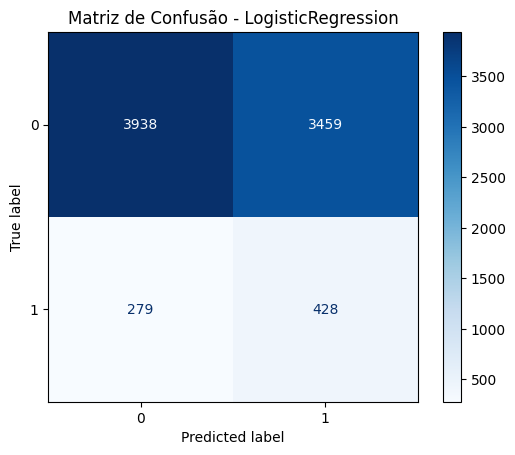

In [9]:
# 8. Matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_grid.best_estimator_.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()


#### Modelo Tree sem otimizações

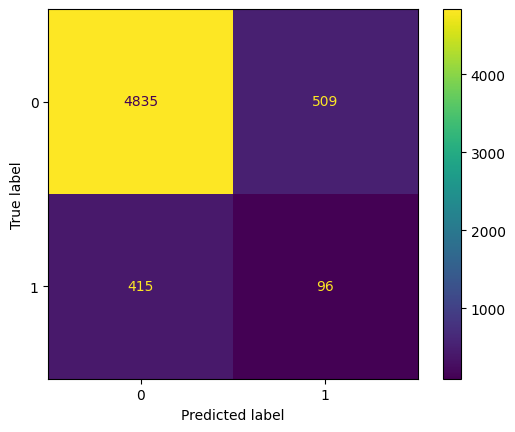

In [10]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
x_treinoP, x_val, y_treinoP, y_val = train_test_split(x_treino, y_treino, random_state = SEED, stratify = y_treino, test_size = 0.15)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
tree.fit(x_treinoP, y_treinoP)
y_predict = tree.predict(x_val)
matrix = confusion_matrix(y_val, y_predict)
grafico = ConfusionMatrixDisplay(matrix, display_labels=tree.classes_)
grafico.plot()